The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
# !pip install d2l==1.0.3


# Momentum
:label:`sec_momentum`

In :numref:`sec_sgd` we reviewed what happens when performing stochastic gradient descent, i.e., when performing optimization where only a noisy variant of the gradient is available. In particular, we noticed that for noisy gradients we need to be extra cautious when it comes to choosing the learning rate in the face of noise. If we decrease it too rapidly, convergence stalls. If we are too lenient, we fail to converge to a good enough solution since noise keeps on driving us away from optimality.

## Basics

In this section, we will explore more effective optimization algorithms, especially for certain types of optimization problems that are common in practice.


### Leaky Averages

The previous section saw us discussing minibatch SGD as a means for accelerating computation. It also had the nice side-effect that averaging gradients reduced the amount of variance. The minibatch stochastic gradient descent can be calculated by:

$$\mathbf{g}_{t, t-1} = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \mathbf{h}_{i, t-1}.
$$

To keep the notation simple, here we used $\mathbf{h}_{i, t-1} = \partial_{\mathbf{w}} f(\mathbf{x}_i, \mathbf{w}_{t-1})$ as the stochastic gradient descent for sample $i$ using the weights updated at time $t-1$.
It would be nice if we could benefit from the effect of variance reduction even beyond averaging gradients on a minibatch. One option to accomplish this task is to replace the gradient computation by a "leaky average":

$$\mathbf{v}_t = \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}$$

for some $\beta \in (0, 1)$. This effectively replaces the instantaneous gradient by one that is been averaged over multiple *past* gradients. $\mathbf{v}$ is called *velocity*. It accumulates past gradients similar to how a heavy ball rolling down the objective function landscape integrates over past forces. To see what is happening in more detail let's expand $\mathbf{v}_t$ recursively into

$$\begin{aligned}
\mathbf{v}_t = \beta^2 \mathbf{v}_{t-2} + \beta \mathbf{g}_{t-1, t-2} + \mathbf{g}_{t, t-1}
= \ldots, = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}.
\end{aligned}$$

Large $\beta$ amounts to a long-range average, whereas small $\beta$ amounts to only a slight correction relative to a gradient method. The new gradient replacement no longer points into the direction of steepest descent on a particular instance any longer but rather in the direction of a weighted average of past gradients. This allows us to realize most of the benefits of averaging over a batch without the cost of actually computing the gradients on it. We will revisit this averaging procedure in more detail later.

The above reasoning formed the basis for what is now known as *accelerated* gradient methods, such as gradients with momentum. They enjoy the additional benefit of being much more effective in cases where the optimization problem is ill-conditioned (i.e., where there are some directions where progress is much slower than in others, resembling a narrow canyon). Furthermore, they allow us to average over subsequent gradients to obtain more stable directions of descent. Indeed, the aspect of acceleration even for noise-free convex problems is one of the key reasons why momentum works and why it works so well.

As one would expect, due to its efficacy momentum is a well-studied subject in optimization for deep learning and beyond. See e.g., the beautiful [expository article](https://distill.pub/2017/momentum/) by :citet:`Goh.2017` for an in-depth analysis and interactive animation. It was proposed by :citet:`Polyak.1964`. :citet:`Nesterov.2018` has a detailed theoretical discussion in the context of convex optimization. Momentum in deep learning has been known to be beneficial for a long time. See e.g., the discussion by :citet:`Sutskever.Martens.Dahl.ea.2013` for details.

### An Ill-conditioned Problem

To get a better understanding of the geometric properties of the momentum method we revisit gradient descent, albeit with a significantly less pleasant objective function. Recall that in :numref:`sec_gd` we used $f(\mathbf{x}) = x_1^2 + 2 x_2^2$, i.e., a moderately distorted ellipsoid objective. We distort this function further by stretching it out in the $x_1$ direction via

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

As before $f$ has its minimum at $(0, 0)$. This function is *very* flat in the direction of $x_1$. Let's see what happens when we perform gradient descent as before on this new function. We pick a learning rate of $0.4$.


epoch 20, x1: -0.943467, x2: -0.000073


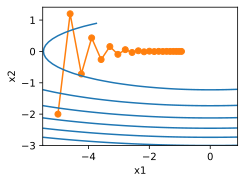

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

By construction, the gradient in the $x_2$ direction is *much* higher and changes much more rapidly than in the horizontal $x_1$ direction. Thus we are stuck between two undesirable choices: if we pick a small learning rate we ensure that the solution does not diverge in the $x_2$ direction but we are saddled with slow convergence in the $x_1$ direction. Conversely, with a large learning rate we progress rapidly in the $x_1$ direction but diverge in $x_2$. The example below illustrates what happens even after a slight increase in learning rate from $0.4$ to $0.6$. Convergence in the $x_1$ direction improves but the overall solution quality is much worse.


epoch 20, x1: -0.387814, x2: -1673.365109


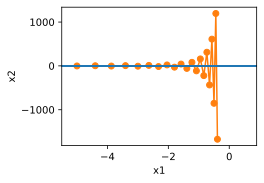

In [3]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

### The Momentum Method

The momentum method allows us to solve the gradient descent problem described
above. Looking at the optimization trace above we might intuit that averaging gradients over the past would work well. After all, in the $x_1$ direction this will aggregate well-aligned gradients, thus increasing the distance we cover with every step. Conversely, in the $x_2$ direction where gradients oscillate, an aggregate gradient will reduce step size due to oscillations that cancel each other out.
Using $\mathbf{v}_t$ instead of the gradient $\mathbf{g}_t$ yields the following update equations:

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}
$$

Note that for $\beta = 0$ we recover regular gradient descent. Before delving deeper into the mathematical properties let's have a quick look at how the algorithm behaves in practice.


epoch 20, x1: 0.007188, x2: 0.002553


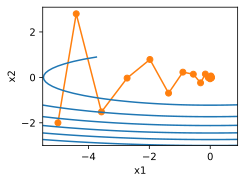

In [4]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

As we can see, even with the same learning rate that we used before, momentum still converges well. Let's see what happens when we decrease the momentum parameter. Halving it to $\beta = 0.25$ leads to a trajectory that barely converges at all. Nonetheless, it is a lot better than without momentum (when the solution diverges).


epoch 20, x1: -0.126340, x2: -0.186632


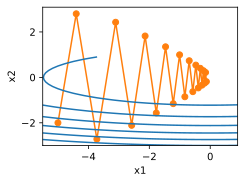

In [5]:
eta, beta = 0.6, 0.25
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

Note that we can combine momentum with stochastic gradient descent and in particular, minibatch stochastic gradient descent. The only change is that in that case we replace the gradients $\mathbf{g}_{t, t-1}$ with $\mathbf{g}_t$. Last, for convenience we initialize $\mathbf{v}_0 = 0$ at time $t=0$. Let's look at what leaky averaging actually does to the updates.

### Effective Sample Weight

Recall that $\mathbf{v}_t = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}$. In the limit the terms add up to $\sum_{\tau=0}^\infty \beta^\tau = \frac{1}{1-\beta}$. In other words, rather than taking a step of size $\eta$ in gradient descent or stochastic gradient descent we take a step of size $\frac{\eta}{1-\beta}$ while at the same time, dealing with a potentially much better behaved descent direction. These are two benefits in one. To illustrate how weighting behaves for different choices of $\beta$ consider the diagram below.


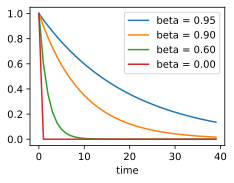

In [6]:
d2l.set_figsize()
betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

## Practical Experiments

Let's see how momentum works in practice, i.e., when used within the context of a proper optimizer. For this we need a somewhat more scalable implementation.

### Implementation from Scratch

Compared with (minibatch) stochastic gradient descent the momentum method needs to maintain a set of  auxiliary variables, i.e., velocity. It has the same shape as the gradients (and variables of the optimization problem). In the implementation below we call these variables `states`.


In [7]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

In [8]:
def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

Let's see how this works in practice.


loss: 0.251, 0.101 sec/epoch


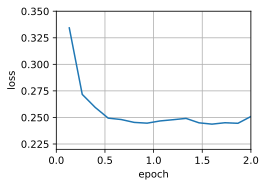

In [9]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter,
                   feature_dim, num_epochs)

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

When we increase the momentum hyperparameter `momentum` to 0.9, it amounts to a significantly larger effective sample size of $\frac{1}{1 - 0.9} = 10$. We reduce the learning rate slightly to $0.01$ to keep matters under control.


loss: 0.248, 0.085 sec/epoch


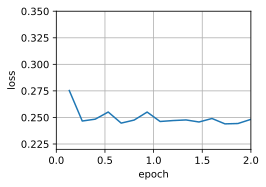

In [10]:
train_momentum(0.01, 0.9)

Reducing the learning rate further addresses any issue of non-smooth optimization problems. Setting it to $0.005$ yields good convergence properties.


loss: 0.243, 0.092 sec/epoch


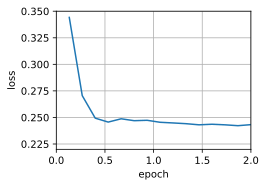

In [11]:
train_momentum(0.005, 0.9)

### Concise Implementation

There is very little to do in Gluon since the standard `sgd` solver already had momentum built in. Setting matching parameters yields a very similar trajectory.


loss: 0.248, 0.097 sec/epoch


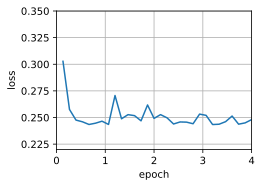

In [12]:
trainer = torch.optim.SGD
d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

## Exercise 1: Exploring Different Combinations of Momentum and Learning Rates

Let's systematically explore different combinations of momentum hyperparameters and learning rates to understand their effects on training convergence and final loss.


EXPERIMENT 1: Effect of Momentum (Fixed eta=0.6)
Mục đích: Quan sát momentum từ 0 → 0.95, ESS từ 1 → 20


eta=0.6, beta=0.0 - No momentum (ESS=1)
  Effective step size: 0.60
epoch 20, x1: -0.387814, x2: -1673.365109


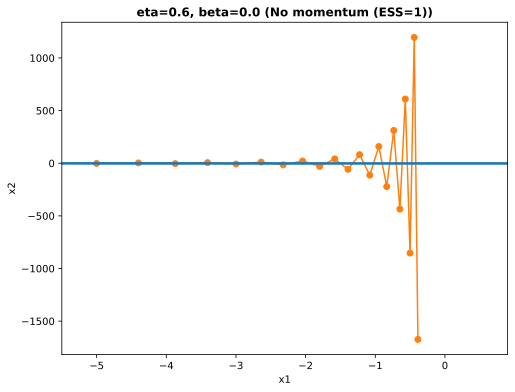


eta=0.6, beta=0.3 - Low momentum (ESS≈1.4)
  Effective step size: 0.86
epoch 20, x1: -0.084378, x2: -0.000643


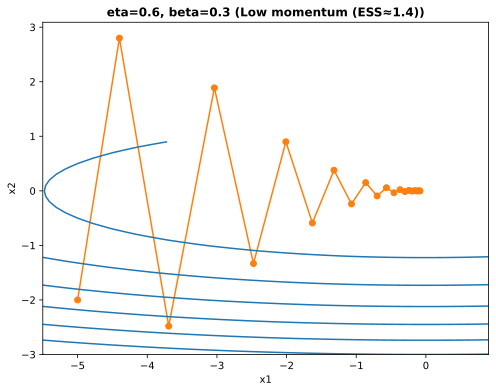


eta=0.6, beta=0.5 - Medium momentum (ESS=2)
  Effective step size: 1.20
epoch 20, x1: 0.007188, x2: 0.002553


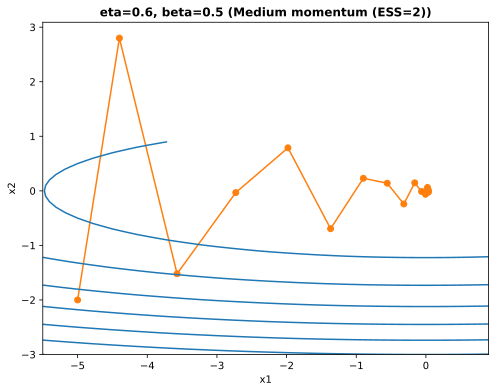


eta=0.6, beta=0.7 - Medium-high (ESS≈3.3)
  Effective step size: 2.00
epoch 20, x1: -0.147652, x2: 0.095252


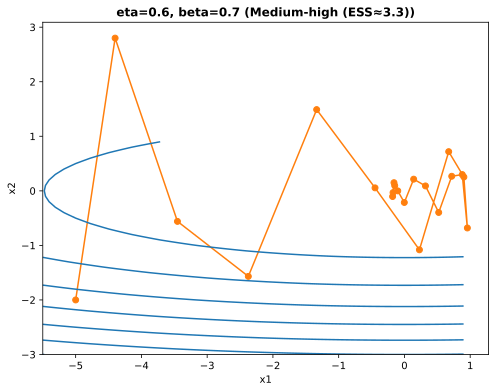


eta=0.6, beta=0.9 - High/Standard (ESS=10)
  Effective step size: 6.00
epoch 20, x1: -1.191637, x2: -1.118465


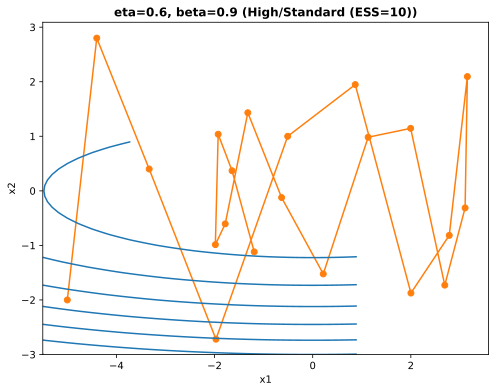


eta=0.6, beta=0.95 - Very high (ESS=20)
  Effective step size: 12.00
epoch 20, x1: -1.973514, x2: -1.417544


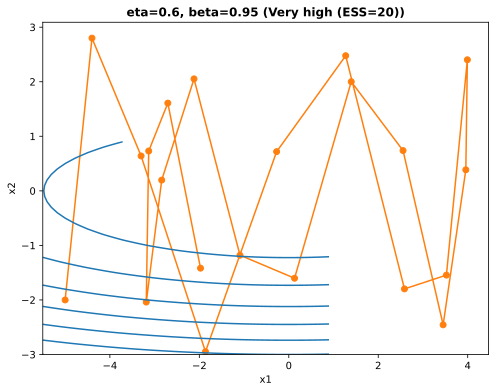


KẾT LUẬN EXPERIMENT 1:
- Beta càng cao → đường đi càng mượt, ít dao động
- Beta=0.0 dao động nhiều, đặc biệt ở hướng x2 (steep)
- Beta > 0.5 bắt đầu phân kì, bước nhảy lớn đã hất văng nghiệm ra xa điểm cực tiểu
=> Khi tăng Beta lên cao, BẮT BUỘC phải giảm Eta xuống

EXPERIMENT 2: Effect of Learning Rate (Fixed beta=0.9)
Mục đích: Với momentum cao, thử các learning rate khác nhau


eta=0.01, beta=0.9 - Very low LR
  Effective step size: 0.10
epoch 20, x1: -3.863375, x2: 0.551171


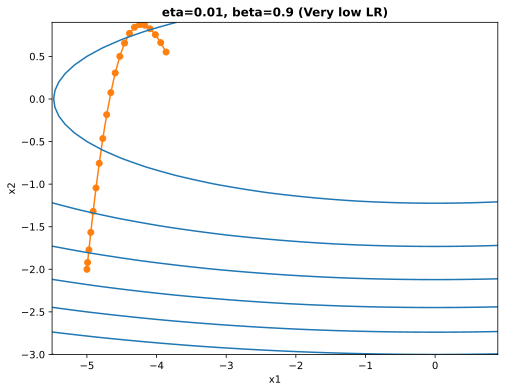


eta=0.05, beta=0.9 - Very low LR
  Effective step size: 0.50
epoch 20, x1: -0.589111, x2: 0.698505


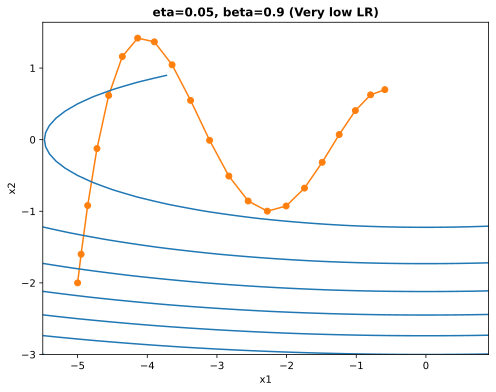


eta=0.1, beta=0.9 - Very low LR
  Effective step size: 1.00
epoch 20, x1: 1.353357, x2: -0.465813


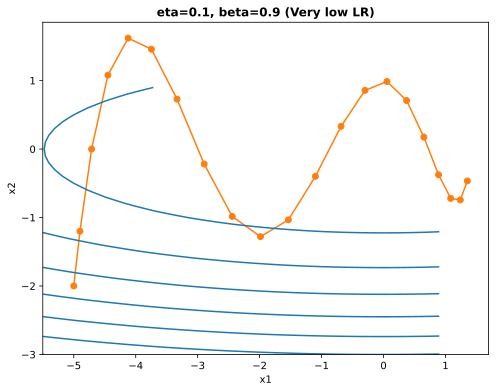


eta=0.2, beta=0.9 - Low LR
  Effective step size: 2.00
epoch 20, x1: 1.377927, x2: -0.621659


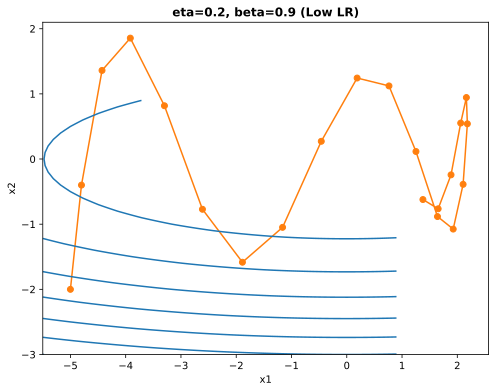


eta=0.4, beta=0.9 - Medium LR
  Effective step size: 4.00
epoch 20, x1: -1.450218, x2: 0.715940


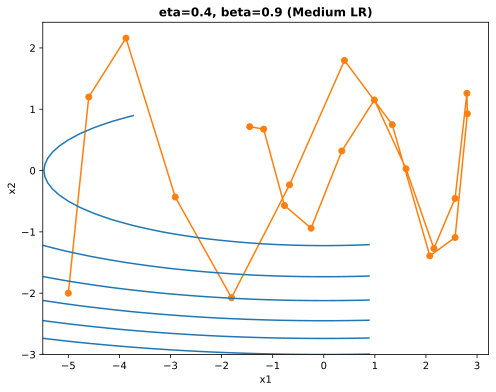


eta=0.6, beta=0.9 - High LR
  Effective step size: 6.00
epoch 20, x1: -1.191637, x2: -1.118465


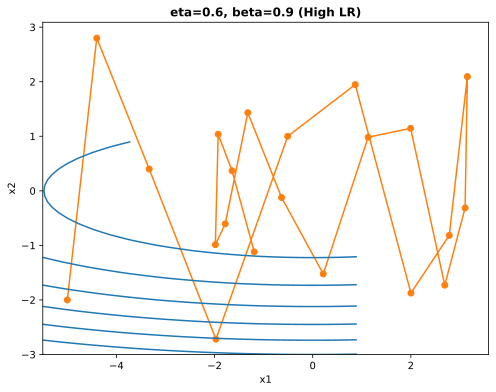


eta=0.8, beta=0.9 - Very high LR
  Effective step size: 8.00
epoch 20, x1: 0.726161, x2: 1.468998


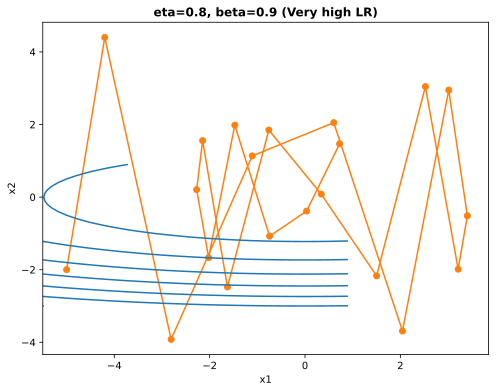


KẾT LUẬN EXPERIMENT 2:
Khi Momentum cao beta=0.9
- nếu eta=0.01 quá nhỏ, tốc độ hội tụ cực chậm
- nếu eta=0.05, hội tụ tốt, giao động ổn định
 - khi eta > 0.05, trạng thái giao động bắt đầu có dấu hiệu giao động mạnh
việc tăng Learning Rate dù rất ít(từ 0.1 lên 0.2) cũng làm tăng Effective Step Size lên gấp đôi, chuyển trạng thái từ 'dao động ổn định' sang 'dao động mạnh/kém hiệu quả'.
=> Khi tăng Beta cao 0.9, nếu eta cao thì sẽ khuếch đại dao động đáng kể, dễ gây ra giao động mạnh dẫn đến phân kỳ

EXPERIMENT 4: Best vs Worst Combinations
Mục đích: Thấy rõ cấu hình tốt và xấu


WORST: High LR + No momentum: eta=0.6, beta=0.0
  Effective step: 0.60, ESS: 1.0
epoch 20, x1: -0.387814, x2: -1673.365109


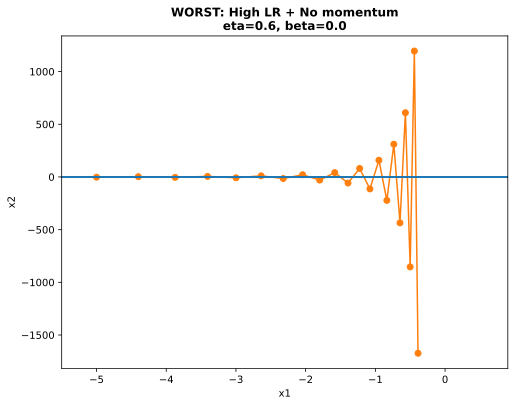


BAD: Too aggressive: eta=0.8, beta=0.9
  Effective step: 8.00, ESS: 10.0
epoch 20, x1: 0.726161, x2: 1.468998


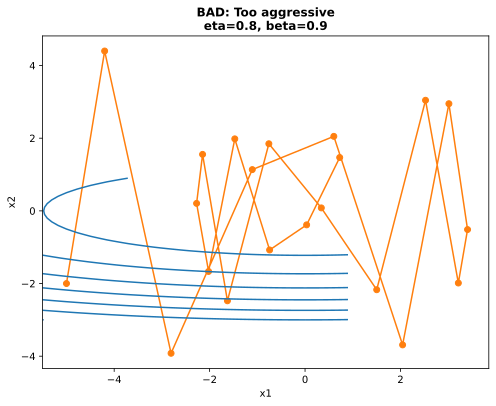


BAD: Too conservative: eta=0.1, beta=0.3
  Effective step: 0.14, ESS: 1.4
epoch 20, x1: -2.816481, x2: -0.000008


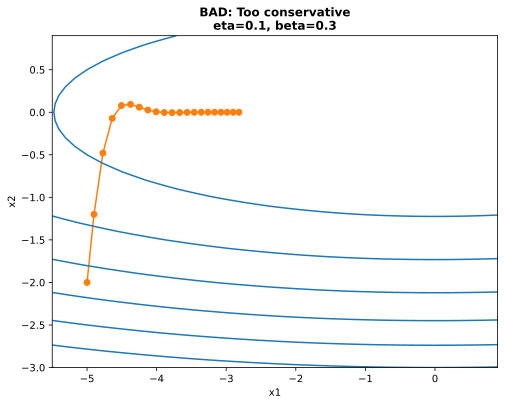


BAD: Too aggressive: eta=0.4, beta=0.9
  Effective step: 4.00, ESS: 10.0
epoch 20, x1: -1.450218, x2: 0.715940


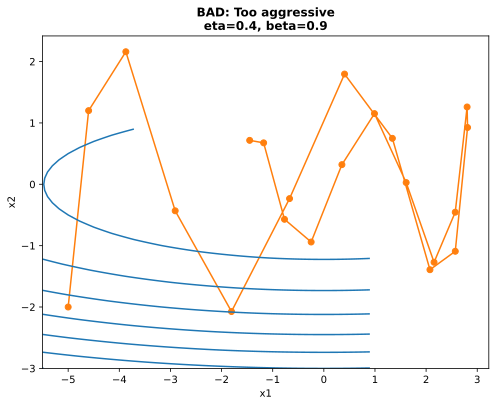


GOOD: Medium combination: eta=0.6, beta=0.5
  Effective step: 1.20, ESS: 2.0
epoch 20, x1: 0.007188, x2: 0.002553


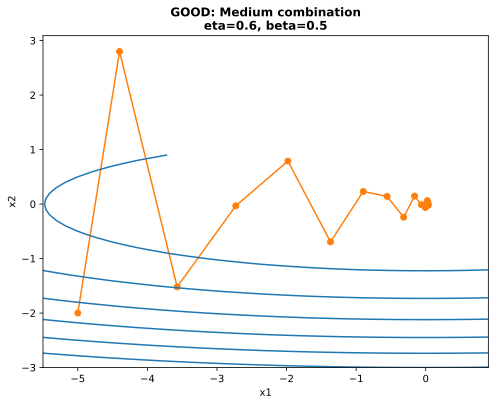


BEST: Safe and smooth: eta=0.05, beta=0.9
  Effective step: 0.50, ESS: 10.0
epoch 20, x1: -0.589111, x2: 0.698505


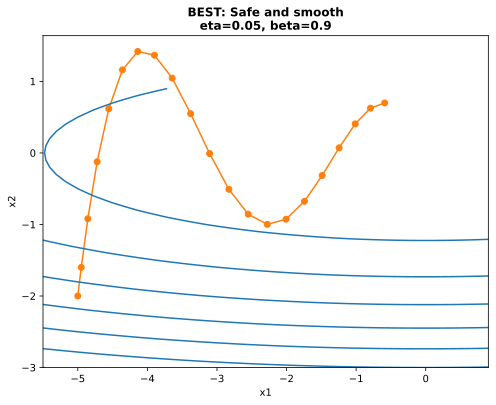


KẾT LUẬN EXPERIMENT 3:
WORST practices:
- Learning Rate cao + Không có Momentum: Dẫn đến dao động mạnh mà không hội tụ được
- eta và beta đều cao → phân kỳ

BEST practices:
- beta cao (0.9) +  eta nhỏ (< 0.6)
- Trade-off: eta↑ → beta↓ để giữ effective step hợp lý
- Với ill-conditioned problems: beta=0.9, eta <= 0.5

KẾT LUẬN TỔNG HỢP

1. MOMENTUM GIÚP:
   - Làm mịn gradient noise (tích lũy ESS gradients)
   - Tăng tốc ở hướng consistent (x1 - flat direction)
   - Giảm dao động ở hướng steep (x2 - steep direction)

2. BEST PRACTICES:
   - Bắt đầu: η=0.4, β=0.9 (effective step ≈ 4)
   - An toàn: η=0.2, β=0.9 (effective step = 2)
   - Nhanh hơn: η=0.6, β=0.9 (effective step = 6)
   - Tránh: β=0 với η cao, hoặc β và η đều cao

3. SO SÁNH VỚI SGD:
   - SGD (β=0): cần η rất nhỏ để ổn định
   - Momentum (β=0.9): có thể dùng η lớn hơn vì smooth hơn
   - Momentum hội tụ nhanh hơn VÀ ổn định hơn



In [60]:
# ============================================================
# SYSTEMATIC EXPERIMENTS FOR CLEAR CONCLUSIONS
# ============================================================
import matplotlib.pyplot as plt

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

# ============================================================
# EXPERIMENT 1: Effect of Momentum (Fixed LR)
# Kết luận: Beta tăng → mượt hơn, ESS tăng, hội tụ tốt hơn
# ============================================================
print("="*70)
print("EXPERIMENT 1: Effect of Momentum (Fixed eta=0.6)")
print("="*70)
print("Mục đích: Quan sát momentum từ 0 → 0.95, ESS từ 1 → 20")
print()

eta = 0.6
beta_experiments = [
    (0.0,  "No momentum (ESS=1)"),
    (0.3,  "Low momentum (ESS≈1.4)"),
    (0.5,  "Medium momentum (ESS=2)"),
    (0.7,  "Medium-high (ESS≈3.3)"),
    (0.9,  "High/Standard (ESS=10)"),
    (0.95, "Very high (ESS=20)"),
]

for beta, description in beta_experiments:
    print(f"\neta={eta}, beta={beta} - {description}")
    print(f"  Effective step size: {eta/(1-beta) if beta < 1 else 'inf':.2f}")
    plt.figure(figsize=(8, 6))
    d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))
    plt.title(f'eta={eta}, beta={beta} ({description})', fontsize=12, fontweight='bold')
    plt.show()

print("\nKẾT LUẬN EXPERIMENT 1:")
print("- Beta càng cao → đường đi càng mượt, ít dao động")
print("- Beta=0.0 dao động nhiều, đặc biệt ở hướng x2 (steep)")
print("- Beta > 0.5 bắt đầu phân kì, bước nhảy lớn đã hất văng nghiệm ra xa điểm cực tiểu")
print("=> Khi tăng Beta lên cao, BẮT BUỘC phải giảm Eta xuống")

# ============================================================
# EXPERIMENT 2: Effect of Learning Rate (Fixed Momentum)
# Kết luận: Với beta=0.9, cần điều chỉnh eta phù hợp
# ============================================================
print("\n" + "="*70)
print("EXPERIMENT 2: Effect of Learning Rate (Fixed beta=0.9)")
print("="*70)
print("Mục đích: Với momentum cao, thử các learning rate khác nhau")
print()

beta = 0.9
eta_experiments = [
    (0.01, "Very low LR"),
    (0.05, "Very low LR"),
    (0.1, "Very low LR"),
    (0.2, "Low LR"),
    (0.4, "Medium LR"),
    (0.6, "High LR"),
    (0.8, "Very high LR"),
]

for eta, description in eta_experiments:
    print(f"\neta={eta}, beta={beta} - {description}")
    print(f"  Effective step size: {eta/(1-beta):.2f}")
    plt.figure(figsize=(8, 6))
    d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))
    plt.title(f'eta={eta}, beta={beta} ({description})', fontsize=12, fontweight='bold')
    plt.show()

print("\nKẾT LUẬN EXPERIMENT 2:")
print("Khi Momentum cao beta=0.9")
print("- nếu eta=0.01 quá nhỏ, tốc độ hội tụ cực chậm")
print("- nếu eta=0.05, hội tụ tốt, giao động ổn định")
print(" - khi eta > 0.05, trạng thái giao động bắt đầu có dấu hiệu giao động mạnh")
print("việc tăng Learning Rate dù rất ít(từ 0.1 lên 0.2) cũng làm tăng Effective Step Size lên gấp đôi, chuyển trạng thái từ 'dao động ổn định' sang 'dao động mạnh/kém hiệu quả'.")
print("=> Khi tăng Beta cao 0.9, nếu eta cao thì sẽ khuếch đại dao động đáng kể, dễ gây ra giao động mạnh dẫn đến phân kỳ")


# ============================================================
# EXPERIMENT 3: Best vs Worst Combinations
# Kết luận: Đưa ra best practices
# ============================================================
print("\n" + "="*70)
print("EXPERIMENT 4: Best vs Worst Combinations")
print("="*70)
print("Mục đích: Thấy rõ cấu hình tốt và xấu")
print()

comparison_experiments = [
    (0.6, 0.0,  "WORST: High LR + No momentum"),
    (0.8, 0.9,  "BAD: Too aggressive"),
    (0.1, 0.3,  "BAD: Too conservative"),
    (0.4, 0.9,  "BAD: Too aggressive"),
    (0.6, 0.5,  "GOOD: Medium combination"),
    (0.05, 0.9,  "BEST: Safe and smooth"),
]

for eta, beta, label in comparison_experiments:
    print(f"\n{label}: eta={eta}, beta={beta}")
    print(f"  Effective step: {eta/(1-beta) if beta < 1 else 'inf':.2f}, ESS: {1/(1-beta):.1f}")
    plt.figure(figsize=(8, 6))
    d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))
    plt.title(f'{label}\neta={eta}, beta={beta}', fontsize=12, fontweight='bold')
    plt.show()

print("\nKẾT LUẬN EXPERIMENT 3:")
print("WORST practices:")
print("- Learning Rate cao + Không có Momentum: Dẫn đến dao động mạnh mà không hội tụ được")
print("- eta và beta đều cao → phân kỳ")
print("\nBEST practices:")
print("- beta cao (0.9) +  eta nhỏ (< 0.6)")
print("- Trade-off: eta↑ → beta↓ để giữ effective step hợp lý")
print("- Với ill-conditioned problems: beta=0.9, eta <= 0.5")

# ============================================================
# FINAL SUMMARY
# ============================================================
print("\n" + "="*70)
print("KẾT LUẬN TỔNG HỢP")
print("="*70)
print("""
1. MOMENTUM GIÚP:
   - Làm mịn gradient noise (tích lũy ESS gradients)
   - Tăng tốc ở hướng consistent (x1 - flat direction)
   - Giảm dao động ở hướng steep (x2 - steep direction)

2. BEST PRACTICES:
   - Bắt đầu: η=0.4, β=0.9 (effective step ≈ 4)
   - An toàn: η=0.2, β=0.9 (effective step = 2)
   - Nhanh hơn: η=0.6, β=0.9 (effective step = 6)
   - Tránh: β=0 với η cao, hoặc β và η đều cao

3. SO SÁNH VỚI SGD:
   - SGD (β=0): cần η rất nhỏ để ổn định
   - Momentum (β=0.9): có thể dùng η lớn hơn vì smooth hơn
   - Momentum hội tụ nhanh hơn VÀ ổn định hơn
""")

### Experiment 5: Visualizing the Impact of Different Combinations

Let's create a more detailed comparison by running experiments with more epochs and tracking the training curves.


loss: 0.242, 0.087 sec/epoch


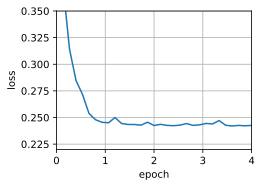

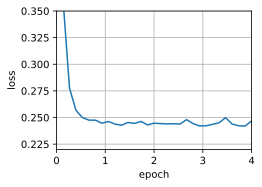

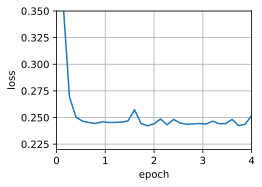

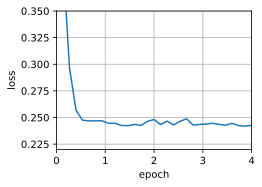

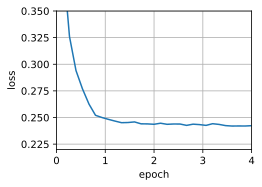

In [17]:
# Compare select combinations with more epochs
print("Comparing Selected Hyperparameter Combinations (4 epochs)")
print("="*60)

# Get fresh data
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)

# Configuration 1: Low momentum, medium lr
print("\n1. Low Momentum + Medium LR")
print("   lr=0.02, momentum=0.3")
train_momentum(0.02, 0.3, num_epochs=4)

# Configuration 2: Medium momentum, medium lr
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
print("\n2. Medium Momentum + Medium LR")
print("   lr=0.01, momentum=0.7")
train_momentum(0.01, 0.7, num_epochs=4)

# Configuration 3: High momentum, low lr (recommended)
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
print("\n3. High Momentum + Low LR (Recommended)")
print("   lr=0.005, momentum=0.9")
train_momentum(0.005, 0.9, num_epochs=4)

# Configuration 4: Very high momentum, very low lr
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
print("\n4. Very High Momentum + Very Low LR")
print("   lr=0.002, momentum=0.95")
train_momentum(0.002, 0.95, num_epochs=4)

# Configuration 5: No momentum baseline
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
print("\n5. Pure SGD (No Momentum)")
print("   lr=0.02, momentum=0.0")
train_momentum(0.02, 0.0, num_epochs=4)


### Summary of Experimental Results

#### Key Findings:

1. **Momentum's Primary Benefits:**
   - Smooths out gradient noise from stochastic sampling
   - Accelerates convergence in consistent descent directions
   - Helps navigate ill-conditioned optimization landscapes
   - Reduces oscillations in steep directions

2. **Relationship Between Momentum and Learning Rate:**
   - They are inversely related: higher momentum → need lower learning rate
   - The effective step size is approximately `lr / (1 - momentum)`
   - Example: `lr=0.01, momentum=0.9` ≈ `lr=0.02, momentum=0.5` in effective step size

3. **Best Practices Observed:**
   - **For stable training**: Start with `lr=0.01, momentum=0.9`
   - **For faster experimentation**: Use `lr=0.02, momentum=0.5`
   - **For fine-tuning**: Try `lr=0.005, momentum=0.9` or `lr=0.002, momentum=0.95`
   - **For comparison baseline**: Always compare against pure SGD (`momentum=0.0`)

4. **Trade-offs:**
   - **High momentum (0.9+)**: Better convergence but less responsive to sudden changes
   - **Low momentum (0.3-0.5)**: More responsive but may oscillate more
   - **High learning rate**: Faster initial progress but risk of instability
   - **Low learning rate**: More stable but slower convergence

5. **Practical Recommendations:**
   - For deep learning: `momentum=0.9` is the standard default
   - Adjust learning rate first, keep momentum fixed at 0.9
   - If training is unstable, decrease learning rate before decreasing momentum
   - If convergence is too slow, try increasing momentum before increasing learning rate

#### When to Use Different Settings:

- **Small, clean datasets**: Medium momentum (0.5-0.7), medium lr (0.01-0.02)
- **Large, noisy datasets**: High momentum (0.9), low-medium lr (0.005-0.01)
- **Ill-conditioned problems**: Very high momentum (0.95), very low lr (0.001-0.005)
- **Quick prototyping**: Low-medium momentum (0.5), medium-high lr (0.02-0.05)


## Theoretical Analysis

So far the 2D example of $f(x) = 0.1 x_1^2 + 2 x_2^2$ seemed rather contrived. We will now see that this is actually quite representative of the types of problem one might encounter, at least in the case of minimizing convex quadratic objective functions.

### Quadratic Convex Functions

Consider the function

$$h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b.$$

This is a general quadratic function. For positive definite matrices $\mathbf{Q} \succ 0$, i.e., for matrices with positive eigenvalues this has a minimizer at $\mathbf{x}^* = -\mathbf{Q}^{-1} \mathbf{c}$ with minimum value $b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$. Hence we can rewrite $h$ as

$$h(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})^\top \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c}) + b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}.$$

The gradient is given by $\partial_{\mathbf{x}} h(\mathbf{x}) = \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$. That is, it is given by the distance between $\mathbf{x}$ and the minimizer, multiplied by $\mathbf{Q}$. Consequently also the velocity  is a linear combination of terms $\mathbf{Q} (\mathbf{x}_t - \mathbf{Q}^{-1} \mathbf{c})$.

Since $\mathbf{Q}$ is positive definite it can be decomposed into its eigensystem via $\mathbf{Q} = \mathbf{O}^\top \boldsymbol{\Lambda} \mathbf{O}$ for an orthogonal (rotation) matrix $\mathbf{O}$ and a diagonal matrix $\boldsymbol{\Lambda}$ of positive eigenvalues. This allows us to perform a change of variables from $\mathbf{x}$ to $\mathbf{z} \stackrel{\textrm{def}}{=} \mathbf{O} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$ to obtain a much simplified expression:

$$h(\mathbf{z}) = \frac{1}{2} \mathbf{z}^\top \boldsymbol{\Lambda} \mathbf{z} + b'.$$

Here $b' = b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$. Since $\mathbf{O}$ is only an orthogonal matrix this does not perturb the gradients in a meaningful way. Expressed in terms of $\mathbf{z}$ gradient descent becomes

$$\mathbf{z}_t = \mathbf{z}_{t-1} - \boldsymbol{\Lambda} \mathbf{z}_{t-1} = (\mathbf{I} - \boldsymbol{\Lambda}) \mathbf{z}_{t-1}.$$

The important fact in this expression is that gradient descent *does not mix* between different eigenspaces. That is, when expressed in terms of the eigensystem of $\mathbf{Q}$ the optimization problem proceeds in a coordinate-wise manner. This also holds for

$$\begin{aligned}
\mathbf{v}_t & = \beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1} \\
\mathbf{z}_t & = \mathbf{z}_{t-1} - \eta \left(\beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1}\right) \\
    & = (\mathbf{I} - \eta \boldsymbol{\Lambda}) \mathbf{z}_{t-1} - \eta \beta \mathbf{v}_{t-1}.
\end{aligned}$$

In doing this we just proved the following theorem: gradient descent with and without momentum for a convex quadratic function decomposes into coordinate-wise optimization in the direction of the eigenvectors of the quadratic matrix.

### Scalar Functions

Given the above result let's see what happens when we minimize the function $f(x) = \frac{\lambda}{2} x^2$. For gradient descent we have

$$x_{t+1} = x_t - \eta \lambda x_t = (1 - \eta \lambda) x_t.$$

Whenever $|1 - \eta \lambda| < 1$ this optimization converges at an exponential rate since after $t$ steps we have $x_t = (1 - \eta \lambda)^t x_0$. This shows how the rate of convergence improves initially as we increase the learning rate $\eta$ until $\eta \lambda = 1$. Beyond that things diverge and for $\eta \lambda > 2$ the optimization problem diverges.


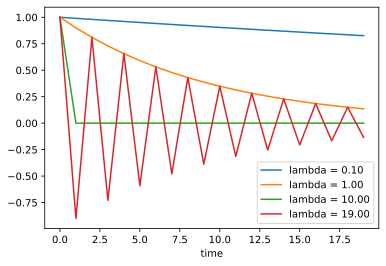

In [18]:
lambdas = [0.1, 1, 10, 19]
eta = 0.1
d2l.set_figsize((6, 4))
for lam in lambdas:
    t = torch.arange(20).detach().numpy()
    d2l.plt.plot(t, (1 - eta * lam) ** t, label=f'lambda = {lam:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

To analyze convergence in the case of momentum we begin by rewriting the update equations in terms of two scalars: one for $x$ and one for velocity $v$. This yields:

$$
\begin{bmatrix} v_{t+1} \\ x_{t+1} \end{bmatrix} =
\begin{bmatrix} \beta & \lambda \\ -\eta \beta & (1 - \eta \lambda) \end{bmatrix}
\begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix} = \mathbf{R}(\beta, \eta, \lambda) \begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix}.
$$

We used $\mathbf{R}$ to denote the $2 \times 2$ governing convergence behavior. After $t$ steps the initial choice $[v_0, x_0]$ becomes $\mathbf{R}(\beta, \eta, \lambda)^t [v_0, x_0]$. Hence, it is up to the eigenvalues of $\mathbf{R}$ to determine the speed of convergence. See the [Distill post](https://distill.pub/2017/momentum/) of :citet:`Goh.2017` for a great animation and :citet:`Flammarion.Bach.2015` for a detailed analysis. One can show that $0 < \eta \lambda < 2 + 2 \beta$ velocity converges. This is a larger range of feasible parameters when compared to $0 < \eta \lambda < 2$ for gradient descent. It also suggests that in general large values of $\beta$ are desirable. Further details require a fair amount of technical detail and we suggest that the interested reader consult the original publications.

## Summary

* Momentum replaces gradients with a leaky average over past gradients. This accelerates convergence significantly.
* It is desirable for both noise-free gradient descent and (noisy) stochastic gradient descent.
* Momentum prevents stalling of the optimization process that is much more likely to occur for stochastic gradient descent.
* The effective number of gradients is given by $\frac{1}{1-\beta}$ due to exponentiated downweighting of past data.
* In the case of convex quadratic problems this can be analyzed explicitly in detail.
* Implementation is quite straightforward but it requires us to store an additional state vector (velocity $\mathbf{v}$).

## Exercises

1. Use other combinations of momentum hyperparameters and learning rates and observe and analyze the different experimental results.
1. Try out gradient descent and momentum for a quadratic problem where you have multiple eigenvalues, i.e., $f(x) = \frac{1}{2} \sum_i \lambda_i x_i^2$, e.g., $\lambda_i = 2^{-i}$. Plot how the values of $x$ decrease for the initialization $x_i = 1$.
1. Derive minimum value and minimizer for $h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b$.
1. What changes when we perform stochastic gradient descent with momentum? What happens when we use minibatch stochastic gradient descent with momentum? Experiment with the parameters?


[Discussions](https://discuss.d2l.ai/t/1070)
